In [1]:
# this sets up basic packages
import numpy as np
import pandas as pd
import astropy.units as u
import astropy.cosmology.units as cu

# this sets up matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# this sets up astropy
from astropy.io import fits
from astropy.table import Table
from astropy.wcs import WCS
from astropy.wcs.utils import pixel_to_skycoord, skycoord_to_pixel
from astropy.utils.data import get_pkg_data_filename
from astropy.coordinates import SkyCoord, Angle, match_coordinates_sky, Distance

In [2]:
# this reads in the new neighbor catalog, originally made for CIGALE
df = pd.read_csv('post_correction_data.csv')

In [3]:
print('Before all the eliminations, there are a total of', df.shape[0], 'sources.')

Before all the eliminations, there are a total of 994 sources.


# CRITERION 1: Minimum of 3 detections, or less if there's A3COSMOS/ALMA data

In [5]:
# in a previous .csv file, all the neighbors are id'd based on their central galaxy.
# since this id is such a minor part of our work and isn't present in our later .csv or .txt files,
# we just retrieve these "our_id" values from the old .csv file, and then use them for our new work.
df2 = pd.read_csv('neighbor_data.csv')
df2 = df2[df2['id'].duplicated(keep='first')==False]
catalog_id = df2['id']
our_id = df2['our_id']
our_ra = df2['ra']
our_dec = df2['dec']
our_z = df2['z_spec']

In [6]:
# this opens the HDU list of the .fits catalog from A3COSMOS
hdu_list = fits.open('/Volumes/LaCie/COSMOS_DATA/a3cosmos_blind.fits')
hdu_list.info()

# this gets the data of the catalog
a3cosmos = hdu_list[1].data

Filename: /Volumes/LaCie/COSMOS_DATA/a3cosmos_blind.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      45   ()      
  1  J_ApJS_244_40_blind    1 BinTableHDU    115   1134R x 16C   [D, D, D, D, E, E, E, E, E, E, E, D, E, E, E, B]   


In [7]:
### matching coords from the A3COSMOS catalog using SkyCoord 
# create SkyCoord arrays (?) with the RA and Dec of the galaxies in both catalogs
radio_cat = SkyCoord(ra=a3cosmos['RAJ2000']*u.degree, dec=a3cosmos['DEJ2000']*u.degree)
spec_cat = SkyCoord(ra=our_ra.values*u.degree, dec=our_dec.values*u.degree)

# use search_around_sky to find matching indices (matching in RA and Dec) in each catalog
idx_radio, idx_spec, d2d, d3d = spec_cat.search_around_sky(radio_cat, 1*u.arcsec)

# use the matching indices to the new catalog to see where we have ground-based data of our neighbors
print(np.size(idx_radio), 'is the number of matches between the A3COSMOS and the spectroscopic catalogs.')

2 is the number of matches between the A3COSMOS and the spectroscopic catalogs.


In [8]:
# this calls the names of all the columns with flux measurements for all the galaxies
f_cols = [col for col in df.columns if '_err' not in col and col != 'id' and col != 'redshift']

In [9]:
# this saves all the neighbor ids that pass criterion 1
crit1_neigh_id = []

# this loops over all the galaxies from the .csv file, then reads their corresponding fluxes
# in all our bands to see if each of them has at least 3 different detections. if said galaxy does, 
# then we save the id of that galaxy, meaning that it passes criterion 1.

# this loops over each of the 9 QGs in our sample group
for id in catalog_id.values:
    
    # this retrieves all the corresponding fluxes of the galaxy with the id called
    all_bands = df[df['id'] == id][f_cols].values

    # this counts how many of these fluxes are non-zeros (i.e. how many detections there are)
    available_fluxes = np.count_nonzero(all_bands)

    # this adds the galaxy's id into crit1_neigh_id if the galaxy has more than 3 detections
    if available_fluxes >= 3:
        crit1_neigh_id.append(id)
        
print(len(crit1_neigh_id), 'is the total amount of neighbors that pass criterion 1.')

849 is the total amount of neighbors that pass criterion 1.


# CRITERION 2: |z$_{QG}$ - z$_{gal}$| < 0.5

In [11]:
# this reads in the results FITS file that CIGALE made
cigale_results = fits.open('out/results.fits')
cigale_results.info()

Filename: out/results.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU    374   994R x 123C   [K, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D]   


In [12]:
# this gets the data from the results FITS file
cigale_data = Table(cigale_results[1].data).to_pandas()

In [13]:
# this selects only the rows in cigale_data and our_id
# whose corresponding source already passed criterion 1
reduced_cigale = cigale_data.loc[cigale_data['id'].isin(crit1_neigh_id)]
reduced_our_id = our_id[catalog_id.isin(crit1_neigh_id)]

In [14]:
cigale_id = reduced_cigale['id'].values
cigale_z = reduced_cigale['bayes.universe.redshift'].values
cigale_z_err = reduced_cigale['bayes.universe.redshift_err'].values

In [15]:
# now read in the RAs and Decs of our 9 galaxies
info = np.genfromtxt('basic_data.txt', delimiter=' ', dtype=['U15', '<f8','<f8', '<f8'])

# this gets the galaxy redshifts for all the 9 galaxies
galaxy_redshift = np.zeros(np.size(info), dtype=float)
for i in range(np.size(info)):
    galaxy_redshift[i] = info[i][3]

In [16]:
# this saves all the neighbor ids that pass criterion 2
crit2_neigh_id = []

# this loops over each of the 9 QGs in our sample group
for our_galaxy in range(np.size(galaxy_redshift)):
    # this selects the neighbor IDs, ONLY the ones that passed criterion 1
    neigh_id = np.array(cigale_id[reduced_our_id==our_galaxy])

    # this reads in the estimated z and errors of all the neighbors around each galaxy that passed criterion 1
    neigh_z = np.array(cigale_z[reduced_our_id==our_galaxy])
    neigh_z_err = np.array(cigale_z_err[reduced_our_id==our_galaxy])

    # this sets criterion 2
    criteria = (np.abs(neigh_z + neigh_z_err - galaxy_redshift[our_galaxy]) <= 0.5) | (np.abs(neigh_z - neigh_z_err - galaxy_redshift[our_galaxy]) <= 0.5)

    # this finds neighbor IDs that pass criterion 2
    ok_neigh_id = neigh_id[criteria]

    # this saves the indices of the neighbors that pass criterion 2
    crit2_neigh_id.extend(ok_neigh_id)

print(len(crit2_neigh_id), 'is the total amount of neighbors that pass criterion 2.')

233 is the total amount of neighbors that pass criterion 2.


Now, we save the plots of the fits that passed both criteria altogether into a separate .pdf file.

In [18]:
import PyPDF2, os

In [19]:
pdfiles = []
for filename in os.listdir('out/'):
    if filename[0:6] in str(crit2_neigh_id) and filename.endswith('.pdf'):
        if filename != 'merged.pdf':
            pdfiles.append(filename)
                        
pdfiles.sort(key = str.lower)

In [20]:
pdfMerge = PyPDF2.PdfMerger()
for filename in pdfiles:
    pdfFile = open('out/' + filename, 'rb')
    pdfReader = PyPDF2.PdfReader(pdfFile)
    pdfMerge.append(pdfReader)
pdfFile.close()
pdfMerge.write('merged.pdf')

# Miscellaneous Eliminations of Bad Fits

First, compare our new sample to our old sample, where there are 160 potential neighbors (see the notebook named <b>eliminate_neighbors_old_data.ipynb</b>). We're doing this just to see how much our two samples differ from one another.

In [23]:
# this reads in the .txt file where we've saved the indices of the potential neighbors
old_potential = np.genfromtxt('old_data_potential_neighbors.txt', dtype=('float','f8'))

In [24]:
# this converts crit2_neigh_id into an array of floats so it's easier to compare
new_potential = np.array(crit2_neigh_id, dtype=('float','f8'))

In [25]:
# this is to find how many common elements are in both arrays
common = np.intersect1d(old_potential, new_potential)

In [26]:
# this reads in the old results file
cigale_old = fits.open('out_all 2.35.35 PM/results.fits')
cigale_old.info()

# this gets the data from the old results file
cigale_old_table = Table(cigale_old[1].data).to_pandas()

# this locates the common potential neighbors in the old results file
info_cigale_old = cigale_old_table.loc[cigale_old_table['id'].isin(common)]

Filename: out_all 2.35.35 PM/results.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU    386   994R x 127C   [K, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D]   


In [27]:
# this locates the common potential neighbors in the new results file
info_cigale_new = cigale_data.loc[cigale_data['id'].isin(common)]

<>:19: SyntaxWarning: invalid escape sequence '\o'
<>:19: SyntaxWarning: invalid escape sequence '\o'
/var/folders/td/xh27mb7x6jz3g1splvmtw7z80000gn/T/ipykernel_4797/92395639.py:19: SyntaxWarning: invalid escape sequence '\o'
  ax[2].set_title('log$_{10}$(M$_*$/M$_\odot$)')


Text(0, 0.5, 'new')

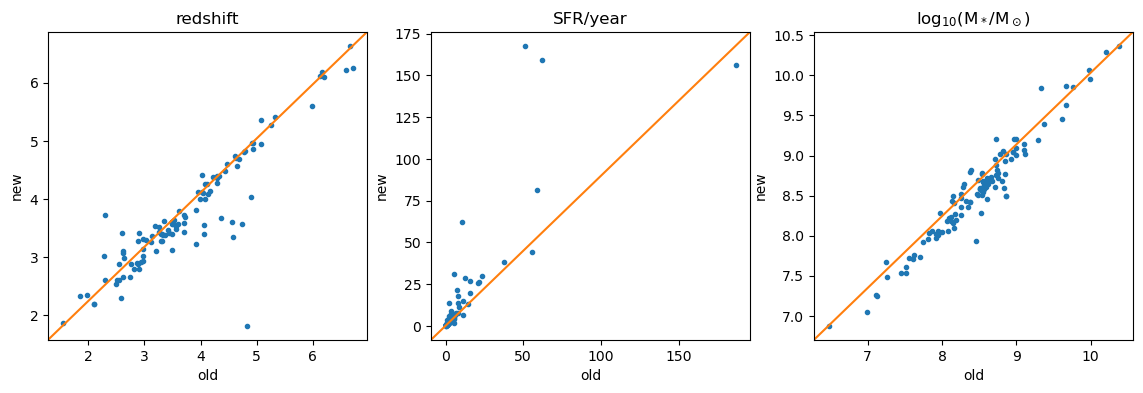

In [28]:
# now we make some diagnostic plots to compare the old and new results
# (only looking at the common potential neighbors in both samples)

fig, ax = plt.subplots(1, 3, figsize=(14, 4))
ax[0].plot(info_cigale_old['bayes.universe.redshift'].values, info_cigale_new['bayes.universe.redshift'].values, '.')
ax[0].plot([0, 1], [0, 1], transform=ax[0].transAxes)
ax[0].set_title('redshift')
ax[0].set_xlabel('old')
ax[0].set_ylabel('new')

ax[1].plot(info_cigale_old['bayes.sfh.sfr'].values, info_cigale_new['bayes.sfh.sfr'].values, '.')
ax[1].plot([0, 1], [0, 1], transform=ax[1].transAxes)
ax[1].set_title('SFR/year')
ax[1].set_xlabel('old')
ax[1].set_ylabel('new')

ax[2].plot(np.log10(info_cigale_old['bayes.stellar.m_star'].values), np.log10(info_cigale_new['bayes.stellar.m_star'].values), '.')
ax[2].plot([0, 1], [0, 1], transform=ax[2].transAxes)
ax[2].set_title('log$_{10}$(M$_*$/M$_\odot$)')
ax[2].set_xlabel('old')
ax[2].set_ylabel('new')

From these plots, we see that the new fits and the old fits are essentially the same, meaning there's no need to reanalyze the potential neighbors selected from the old sample. Since we already saved the IDs of the good fits selected from the old sample, we'll just use that list.

In [30]:
# this reads in the .txt file where we've saved the indices of the potential 
# neighbors with good fits, as selected from the old sample
old_good_fits_idx = np.genfromtxt('old_good_fits.txt', dtype=('float','f8'))

# now, we pick out the ones that are good fits and are also common between the old and new samples
good_fits_1 = np.intersect1d(common, old_good_fits_idx)

In [31]:
# this takes the data of all the new fits based on the indices from the old good fits
good_fits_from_old = cigale_data.loc[cigale_data['id'].isin(good_fits_1)]

Next, we visually inspect the neighbors that did not appear in our old sample.

In [33]:
# we pick out the IDs of the new fits
other_new_fits = np.setdiff1d(new_potential, common)

In [34]:
# now, we make a PDF file of all the plots of the new fits. this is so that it's easier to visually inspect them all
import PyPDF2, os

pdfiles = []
for filename in os.listdir('out/'):
    if filename[0:6] in str(other_new_fits) and filename.endswith('.pdf'):
        pdfiles.append(filename)
                        
pdfiles.sort(key = str.lower)

pdfMerge = PyPDF2.PdfMerger()
for filename in pdfiles:
    pdfFile = open('out/' + filename, 'rb')
    pdfReader = PyPDF2.PdfReader(pdfFile)
    pdfMerge.append(pdfReader)
pdfFile.close()
pdfMerge.write('all_new_fits.pdf')

After making a list of visually inspected bad fits, we pick out the good fits and save them.

In [36]:
# this reads in the .txt file where we've saved the indices of the bad fits
new_bad_fits_idx = np.genfromtxt('new_bad_fits.txt', dtype=('float','f8'))

# now, we pick out the ones that are not "bad fits", and are also common between the old and new samples
# NOTE that these aren't necessary "good fits". there are some fits that we're unable to visually inspect
# because CIGALE can't plot them for some reason. for those ones, we'll just discard the fits.
other_fits = np.setdiff1d(other_new_fits, new_bad_fits_idx)

In [37]:
# now, we make a PDF file of all the plots of the new fits. this is so that it's easier to visually inspect them all
import PyPDF2, os

# this creates a secondary list that saves only the IDs of the non-bad fits that have plots 
# which we've visually inspected--i.e. fits that have been confirmed to be good.
good_fits_2 = []

pdfiles = []
for filename in os.listdir('out/'):
    if filename[0:6] in str(other_fits) and filename.endswith('.pdf'):
        pdfiles.append(filename)

        # this saves the names of only the fits that are non-bad and have plots which
        # we've visually inspected, i.e. fits we've confirmed to be good
        good_fits_2.append(float(filename[0:6]))
                        
pdfiles.sort(key = str.lower)

pdfMerge = PyPDF2.PdfMerger()
for filename in pdfiles:
    pdfFile = open('out/' + filename, 'rb')
    pdfReader = PyPDF2.PdfReader(pdfFile)
    pdfMerge.append(pdfReader)
pdfFile.close()
pdfMerge.write('good_fits.pdf')

In [38]:
good_fits_2 = np.array(good_fits_2, dtype='object')

In [39]:
# now, make an array of all the good fits
all_good_fits = np.concatenate((good_fits_1, good_fits_2))

In [40]:
# retrieve all the relevant info for the good fits from CIGALE's data table
info_good_fits = cigale_data.loc[cigale_data['id'].isin(all_good_fits)] # candi: short for candidate

In [41]:
info_good_fits

,id,bayes.attenuation.E_BVs,bayes.attenuation.E_BVs_err,bayes.sfh.age_main,bayes.sfh.age_main_err,bayes.universe.redshift,bayes.universe.redshift_err,bayes.sfh.sfr,bayes.sfh.sfr_err,bayes.sfh.sfr100Myrs,...,best.subaru.suprime.IB427,best.subaru.suprime.IB505,best.subaru.suprime.IB574,best.subaru.suprime.IB709,best.subaru.suprime.IB827,best.subaru.suprime.NB711,best.subaru.suprime.NB816,best.spitzer.irac.ch1,best.spitzer.irac.ch2,best.spitzer.irac.ch3
0,756228,0.088857,0.035769,417.624948,354.005857,3.278320,0.525038,3.558649,1.834240,2.915679,...,1.467487e-05,3.040419e-05,0.000063,0.000065,0.000071,0.000065,0.000071,1.196896e-04,1.428054e-04,1.476414e-04
2,756324,0.142144,0.081505,526.144334,365.795022,3.136364,0.510097,3.385109,2.849470,2.944019,...,1.228186e-05,4.935640e-05,0.000037,0.000043,0.000043,0.000043,0.000043,1.022433e-04,1.066111e-04,1.009454e-04
5,756381,0.089931,0.002999,100.658272,22.407275,3.601789,0.055604,7.290918,0.364546,3.845178,...,1.186805e-05,5.654811e-05,0.000117,0.000121,0.000124,0.000120,0.000124,1.232406e-04,1.542069e-04,1.061178e-04
14,756542,0.249534,0.008622,100.170514,11.594269,4.401081,0.286135,13.469845,1.298317,7.477333,...,-3.560853e-10,3.060166e-07,0.000010,0.000035,0.000041,0.000036,0.000041,1.587561e-04,9.742184e-05,1.379322e-04
19,756650,0.450849,0.021279,100.002315,1.087818,3.599899,0.021833,19.724432,1.713810,10.549690,...,3.704218e-07,3.433116e-06,0.000009,0.000013,0.000015,0.000013,0.000015,1.311768e-04,2.264904e-04,1.855936e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
978,823998,0.006525,0.019346,484.234110,417.265533,4.258428,0.979942,1.457550,0.721397,1.414571,...,0.000000e+00,0.000000e+00,0.000003,0.000013,0.000060,0.000012,0.000060,2.368231e-05,3.938737e-05,2.702594e-05
981,824034,0.006721,0.016807,497.113674,337.545777,2.540534,0.277544,0.228684,0.087718,0.219566,...,1.675115e-05,1.766437e-05,0.000017,0.000017,0.000016,0.000017,0.000017,1.841179e-05,1.685075e-05,1.723205e-05
983,824065,0.014784,0.028866,334.670839,336.738491,3.015252,0.670935,0.487810,0.221449,0.374835,...,5.108543e-06,1.824325e-05,0.000030,0.000026,0.000024,0.000026,0.000024,1.584817e-05,2.062088e-05,1.368695e-05
986,824112,0.000951,0.006105,141.500567,319.473322,2.640952,0.979775,0.037928,0.020141,0.023401,...,6.570203e-07,2.140676e-06,0.000003,0.000003,0.000002,0.000003,0.000002,9.138732e-07,9.695734e-07,7.496797e-07


# Searching for Quenched Neighbors

Now, let's calculate the specific star formation rate (sSFR) of all the good-fit galaxies to see which ones are quenched. 

The equation for sSFR is as follows for each galaxy:
$$
sSFR=log_{10}(\frac{SFR}{M_*})
$$
For our intents and purposes, a galaxy is quenched if <b>sSFR < -9.8</b>.

In [44]:
# calculate sSFR. "all_candis" means "all candidates". I'm just too lazy to spell it all out.
ssfr_all_candis_bayes = np.log10(info_good_fits['bayes.sfh.sfr'].values / info_good_fits['bayes.stellar.m_star'].values)
ssfr_all_candis_best = np.log10(info_good_fits['best.sfh.sfr'].values / info_good_fits['best.stellar.m_star'].values)

Text(0, 0.5, 'amount')

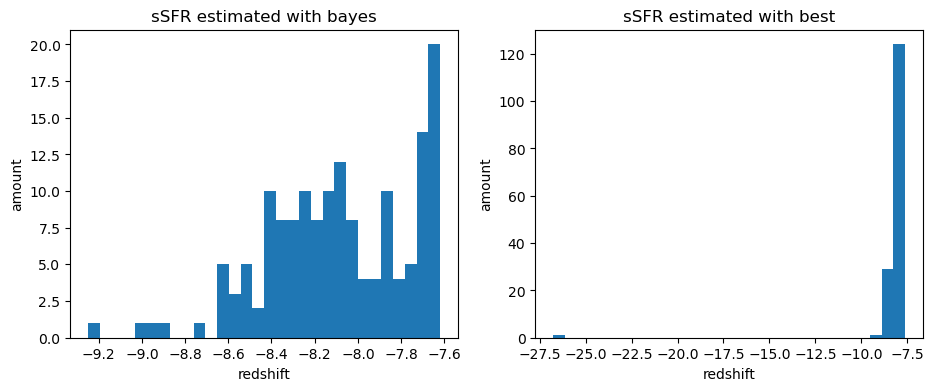

In [45]:
# now we make two histograms to compare how many quenched neighbors are identified with either bayes or best
fig, ax = plt.subplots(1, 2, figsize=(11, 4))
ax[0].hist(ssfr_all_candis_bayes, bins=30)
ax[0].set_title('sSFR estimated with bayes')
ax[0].set_xlabel('redshift')
ax[0].set_ylabel('amount')

ax[1].hist(ssfr_all_candis_best, bins=30)
ax[1].set_title('sSFR estimated with best')
ax[1].set_xlabel('redshift')
ax[1].set_ylabel('amount')

(-9.9, -7.484999999999999)

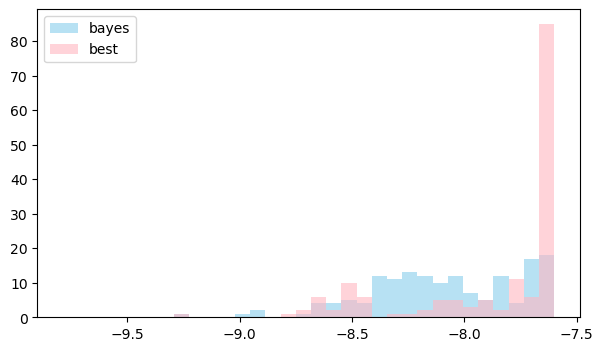

In [46]:
fig, ax = plt.subplots(figsize=(7,4))
plt.hist(ssfr_all_candis_bayes, bins=np.linspace(-9.9, -7.6, 35), color="skyblue", alpha=0.6, label='bayes')
plt.hist(ssfr_all_candis_best, bins=np.linspace(-9.9, -7.6, 35), color="lightpink", alpha=0.6, label='best')
plt.legend()
plt.xlim(-9.9)

So from the sSFRs estimated with best, we do find quenched neighbors. How many of them do we have, exactly? And which central galaxies do they belong to?

In [48]:
quenched = info_good_fits[ssfr_all_candis_best < -9.8]['id'].values

In [49]:
# now, we're going to look for the indices associated with the central galaxies 
# of the potential quenched neighbor(s) we have. remember: those are indices that
# we ourselves assigned, ranging from 0 to 8 for our sample of 9 QGs.

# first, load in the CSV file that contains our assigned indices
neigh_file = pd.read_csv('neighbor_data.csv')

# next, read in the TXT file with the basic info of our 9 galaxies,
# whose rows follow the order of our assigned indices
info = np.genfromtxt('basic_data.txt', delimiter=' ', dtype=['U15', '<f8','<f8', '<f8'])

# finally, loop through the list of potential quenched neighbors
# and find the assigned indices that are associated with their central galaxies
for i in range(np.size(quenched)):
    central_id = neigh_file['our_id'][neigh_file['id']==quenched[i]]
    # now print the basic info of the central galaxy associated with each quenched neighbor
    print(info[central_id])

[('Bach-Dang', 150.11256, 2.3765266, 2.474)]


So there's only one quenched neighbor of one quenched galaxy. What does that quenched neighbor's fit look like?

<b>Thursday, August 22, 2024:</b> Let's take a break here and come back later

# Exporting a Final DataFrame

Now, we make one FINAL DataFrame with all our potential neighbors. We also retrieve their RA and Dec from the original <b>neighbor_data.csv</b> file.


In [53]:
# these lines retrieve their RA and Dec from the original neighbor_data.csv file
good_fits_ra = df2[['id', 'ra']].loc[catalog_id.isin(info_good_fits['id'].values)]
good_fits_dec = df2[['id', 'dec']].loc[catalog_id.isin(info_good_fits['id'].values)]

In [54]:
# this creates a DataFrame with the RA and Dec of our good-fits neighbors
good_fits_df = pd.merge(pd.merge(info_good_fits, good_fits_ra, on="id", how="left"), good_fits_dec, on="id", how="left")

In [55]:
final_df = good_fits_df[['id', 'ra', 'dec', 'bayes.universe.redshift', 'bayes.universe.redshift_err', 
                         'bayes.stellar.m_star', 'bayes.stellar.m_star_err', 'bayes.sfh.sfr', 
                         'bayes.sfh.sfr_err', 'bayes.sfh.sfr100Myrs', 'bayes.sfh.sfr100Myrs_err', 
                         'bayes.attenuation.E_BVs', 'bayes.attenuation.E_BVs_err']]

## <b>BEHOLD!</b> Our final table!

In [57]:
print(final_df)

         id          ra       dec  bayes.universe.redshift  \
0    756228  150.061200  2.374627                 3.278320   
1    756324  150.062186  2.375231                 3.136364   
2    756381  150.058607  2.377135                 3.601789   
3    756542  150.064461  2.376458                 4.401081   
4    756650  150.059622  2.379230                 3.599899   
..      ...         ...       ...                      ...   
150  823998  150.106560  2.333423                 4.258428   
151  824034  150.108001  2.333181                 2.540534   
152  824065  150.112878  2.331558                 3.015252   
153  824112  150.110146  2.332911                 2.640952   
154  824190  150.108294  2.334233                 4.143219   

     bayes.universe.redshift_err  bayes.stellar.m_star  \
0                       0.525038          4.061610e+08   
1                       0.510097          4.636836e+08   
2                       0.055604          3.171661e+08   
3                      

## NOTES: Aug 20, 2024.<br>
### formatting stuff for our table:<br>
### M*: log10(mass) $\pm$ (0.434$\frac{uncertainty}{mass}$)<br>
### SFR: leave NO decimal
### z$_{phot}$: leave one significant figure (tenth decimal), same for error
### RA, Dec: follow form 00:00:00.00 (use code)
### log10(specific SFR) where Specific SFR = $\frac{SFR}{M*}$ and follows form "-8.2" or "-12"
### in cases where specific SFR < -12, just say "< -12".
### in cases where SFR is beyond one decimal point (0.03) then write 0. maybe note this down.

In [59]:
final_df[['ra', 'dec', 'bayes.stellar.m_star', 'bayes.sfh.sfr', 'bayes.universe.redshift']]

,ra,dec,bayes.stellar.m_star,bayes.sfh.sfr,bayes.universe.redshift
0,150.061200,2.374627,4.061610e+08,3.558649,3.278320
1,150.062186,2.375231,4.636836e+08,3.385109,3.136364
2,150.058607,2.377135,3.171661e+08,7.290918,3.601789
3,150.064461,2.376458,6.127644e+08,13.469845,4.401081
4,150.059622,2.379230,8.667085e+08,19.724432,3.599899
...,...,...,...,...,...
150,150.106560,2.333423,2.299701e+08,1.457550,4.258428
151,150.108001,2.333181,3.390000e+07,0.228684,2.540534
152,150.112878,2.331558,4.760431e+07,0.487810,3.015252
153,150.110146,2.332911,1.963230e+06,0.037928,2.640952


In [60]:
# this saves the RA and Dec into 00:00:00.00 format, which we'll then use for our LaTeX table.
# the code was copy-pasted from Arianna, of course.
save_coords = SkyCoord(final_df['ra'].values*u.deg, final_df['dec'].values*u.deg)
ras = []
decs = []
for i in zip(save_coords.ra.hms[0], save_coords.ra.hms[1],save_coords.ra.hms[2]):
    if (len(str(round(i[2],2))) >= 5):
        ras.append(str(round(i[0])).zfill(2)+':'+str(round(i[1])).zfill(2)+':'+str(round(i[2],2)).zfill(4))
    elif ((len(str(round(i[2],2))) == 4) & (round(i[2],2) < 10)):
        ras.append(str(round(i[0])).zfill(2)+':'+str(round(i[1])).zfill(2)+':'+str(round(i[2],2)).zfill(5))
    else:
        ras.append(str(round(i[0])).zfill(2)+':'+str(round(i[1])).zfill(2)+':'+str(round(i[2],2)).zfill(4))
for i in zip(save_coords.dec.dms[0], save_coords.dec.dms[1],save_coords.dec.dms[2]):
    if (len(str(round(i[2],2))) >= 5):
        decs.append('$+$'+str(round(i[0])).zfill(2)+':'+str(round(i[1])).zfill(2)+':'+str(round(i[2],2)).zfill(4))
    elif ((len(str(round(i[2],2))) == 4) & (round(i[2],2) < 10)):
        decs.append('$+$'+str(round(i[0])).zfill(2)+':'+str(round(i[1])).zfill(2)+':'+str(round(i[2],2)).zfill(5))
    else:
        decs.append('$+$'+str(round(i[0])).zfill(2)+':'+str(round(i[1])).zfill(2)+':'+str(round(i[2],2)).zfill(4))

In [61]:
# first, this makes a TXT file of the good fits to send to Erini
f = open('good_fits_ra_dec.txt', 'w')
for i in range(np.size(ras)):
    each_line = str(final_df['id'].values[i]) + ' ' + str(ras[i]) + ' +' + str(decs[i][3:]) + '\n'
    f.write(each_line)

f.close()

In [62]:
# this saves the redshift values into one-decimal form, which we'll use for our LaTeX table.
photz_values = np.round(final_df['bayes.universe.redshift'].values, 1)
photz_errors_unrounded = final_df['bayes.universe.redshift_err'].values
photz = []
for z_idx in range(np.size(photz_values)):
    photz_err = photz_errors_unrounded[z_idx]
    # this checks to see if the redshift error is too close to 0. then we round it up to 0.1.
    if np.abs(0.1 - photz_err) > photz_err:
        photz.append(str(photz_values[z_idx]) + ' $' + chr(92) + 'pm$ ' + str(0.1))
    else:
        photz_err_rounded = np.round(photz_err, 1)
        photz.append(str(photz_values[z_idx]) + ' $' + chr(92) + 'pm$ ' + str(photz_err_rounded))

In [63]:
# this saves the M* into log10(mass) +- (0.434*uncertainty/mass) form, which we'll use for our LaTeX table.
mass_values = np.round(np.log10(final_df['bayes.stellar.m_star'].values), 1)
mass_errors_unrounded = 0.434 * final_df['bayes.stellar.m_star_err'].values / final_df['bayes.stellar.m_star'].values
mass = []
for m_idx in range(np.size(mass_values)):
    mass_err = mass_errors_unrounded[m_idx]
    # this checks to see if the mass error is too close to 0. then we round it up to 0.1.
    if np.abs(0.1 - mass_err) > mass_err:
        mass.append(str(mass_values[m_idx]) + ' $' + chr(92) + 'pm$ ' + str(0.1))
    else:
        mass_err_rounded = np.round(mass_err, 1)
        mass.append(str(mass_values[m_idx]) + ' $' + chr(92) + 'pm$ ' + str(mass_err_rounded))

In [64]:
# this saves the SFR values into decimal-less form, which we'll use for our LaTeX table.
sfr_values = np.int64(final_df['bayes.sfh.sfr'].values)
sfr_errors_unrounded = final_df['bayes.sfh.sfr_err'].values
sfr = []
for sfr_idx in range(np.size(sfr_values)):
    sfr_err = sfr_errors_unrounded[sfr_idx]
    # this checks to see if the SFR error is too close to 0. then we round it up to 1.
    if sfr_err > 0 and sfr_err < 1:
        sfr.append(str(sfr_values[sfr_idx]) + ' $' + chr(92) + 'pm$ ' + str(1))
    else:
        sfr_err_rounded = np.int64(sfr_err)
        sfr.append(str(sfr_values[sfr_idx]) + ' $' + chr(92) + 'pm$ ' + str(sfr_err_rounded))

In [65]:
# this saves the SSFR values
ssfr_calc = np.log10(final_df['bayes.sfh.sfr'].values / final_df['bayes.stellar.m_star'].values)
ssfr = []
for ssfr_value in ssfr_calc:
    ssfr.append('$-$' + str(np.round(np.abs(ssfr_value), 1)))

In [66]:
latex_table = {'R.A.': ras, 'Decl.': decs, 'z$_{phot}$': photz, 
               'log$_{10}$(M$_*$/M$_\odot$)': mass, 'SFR(M$_*$/yr)': sfr, 'log$_{10}$(sSFR/yr)': ssfr}
latex = pd.DataFrame(latex_table)

<>:2: SyntaxWarning: invalid escape sequence '\o'
<>:2: SyntaxWarning: invalid escape sequence '\o'
/var/folders/td/xh27mb7x6jz3g1splvmtw7z80000gn/T/ipykernel_4797/707299128.py:2: SyntaxWarning: invalid escape sequence '\o'
  'log$_{10}$(M$_*$/M$_\odot$)': mass, 'SFR(M$_*$/yr)': sfr, 'log$_{10}$(sSFR/yr)': ssfr}


In [67]:
latex

,R.A.,Decl.,z$_{phot}$,log$_{10}$(M$_*$/M$_\odot$),SFR(M$_*$/yr),log$_{10}$(sSFR/yr)
0,10:00:14.69,$+$02:22:28.66,3.3 $\pm$ 0.5,8.6 $\pm$ 0.2,3 $\pm$ 1,$-$8.1
1,10:00:14.92,$+$02:22:30.83,3.1 $\pm$ 0.5,8.7 $\pm$ 0.2,3 $\pm$ 2,$-$8.1
2,10:00:14.07,$+$02:22:37.69,3.6 $\pm$ 0.1,8.5 $\pm$ 0.1,7 $\pm$ 1,$-$7.6
3,10:00:15.47,$+$02:22:35.25,4.4 $\pm$ 0.3,8.8 $\pm$ 0.1,13 $\pm$ 1,$-$7.7
4,10:00:14.31,$+$02:22:45.23,3.6 $\pm$ 0.1,8.9 $\pm$ 0.1,19 $\pm$ 1,$-$7.6
...,...,...,...,...,...,...
150,10:00:25.57,$+$02:20:00.32,4.3 $\pm$ 1.0,8.4 $\pm$ 0.3,1 $\pm$ 1,$-$8.2
151,10:00:25.92,$+$02:19:59.45,2.5 $\pm$ 0.3,7.5 $\pm$ 0.2,0 $\pm$ 1,$-$8.2
152,10:00:27.09,$+$02:19:53.61,3.0 $\pm$ 0.7,7.7 $\pm$ 0.2,0 $\pm$ 1,$-$8.0
153,10:00:26.43,$+$02:19:58.48,2.6 $\pm$ 1.0,6.3 $\pm$ 0.2,0 $\pm$ 1,$-$7.7


In [68]:
print(latex.to_latex(index=False))

\begin{tabular}{llllll}
\toprule
R.A. & Decl. & z$_{phot}$ & log$_{10}$(M$_*$/M$_\odot$) & SFR(M$_*$/yr) & log$_{10}$(sSFR/yr) \\
\midrule
10:00:14.69 & $+$02:22:28.66 & 3.3 $\pm$ 0.5 & 8.6 $\pm$ 0.2 & 3 $\pm$ 1 & $-$8.1 \\
10:00:14.92 & $+$02:22:30.83 & 3.1 $\pm$ 0.5 & 8.7 $\pm$ 0.2 & 3 $\pm$ 2 & $-$8.1 \\
10:00:14.07 & $+$02:22:37.69 & 3.6 $\pm$ 0.1 & 8.5 $\pm$ 0.1 & 7 $\pm$ 1 & $-$7.6 \\
10:00:15.47 & $+$02:22:35.25 & 4.4 $\pm$ 0.3 & 8.8 $\pm$ 0.1 & 13 $\pm$ 1 & $-$7.7 \\
10:00:14.31 & $+$02:22:45.23 & 3.6 $\pm$ 0.1 & 8.9 $\pm$ 0.1 & 19 $\pm$ 1 & $-$7.6 \\
10:00:14.91 & $+$02:22:47.82 & 3.4 $\pm$ 0.1 & 8.8 $\pm$ 0.2 & 4 $\pm$ 1 & $-$8.2 \\
10:00:14.89 & $+$02:22:48.23 & 3.6 $\pm$ 0.2 & 9.2 $\pm$ 0.1 & 1 $\pm$ 1 & $-$8.9 \\
10:00:14.18 & $+$02:22:55.11 & 3.4 $\pm$ 0.3 & 8.5 $\pm$ 0.1 & 6 $\pm$ 1 & $-$7.6 \\
10:00:14.71 & $+$02:22:53.56 & 3.7 $\pm$ 0.2 & 9.2 $\pm$ 0.1 & 6 $\pm$ 3 & $-$8.4 \\
10:00:14.27 & $+$02:22:33.11 & 3.3 $\pm$ 0.7 & 8.4 $\pm$ 0.2 & 1 $\pm$ 1 & $-$8.3 \\
10:00:15.

In [69]:
# now, save a simplified .txt files to make postage stamps
final_df[['id', 'ra', 'dec']].to_csv('potential_neighbors.txt', sep='\t', index=False)